In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
tf.random.set_seed(42)

class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # ICRNN
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.relu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.relu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

In [21]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(1):
    X_train = np.load("data/X_train.npy")
    X_test = np.load("data/X_test.npy")
    y_train = np.load("data/y_train.npy")
    y_test_normalized = np.load("data/y_test_normalized.npy")

    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    model = Sequential()
    model.add(RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True))
    model.add(RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=False))
    model.add(Dense(2, activation='linear'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.25, verbose=2)
    training_loss[i] = history.history['val_loss'][-1]
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    name = 'icrnn_64_'
    name = name + str(noise[i]) + '.h5'
    model.save(name)

model.summary()

Epoch 1/50
1402/1402 - 123s - loss: 0.1649 - mean_squared_error: 0.1649 - val_loss: 0.0897 - val_mean_squared_error: 0.0897 - 123s/epoch - 88ms/step
Epoch 2/50
1402/1402 - 47s - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.0739 - val_mean_squared_error: 0.0739 - 47s/epoch - 33ms/step
Epoch 3/50
1402/1402 - 46s - loss: 0.0976 - mean_squared_error: 0.0976 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - 46s/epoch - 33ms/step
Epoch 4/50
1402/1402 - 47s - loss: 0.0946 - mean_squared_error: 0.0946 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - 47s/epoch - 34ms/step
Epoch 5/50
1402/1402 - 47s - loss: 0.0931 - mean_squared_error: 0.0931 - val_loss: 0.0721 - val_mean_squared_error: 0.0721 - 47s/epoch - 34ms/step
Epoch 6/50
1402/1402 - 46s - loss: 0.0924 - mean_squared_error: 0.0924 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - 46s/epoch - 33ms/step
Epoch 7/50
1402/1402 - 47s - loss: 0.0918 - mean_squared_error: 0.0918 - val_loss: 0.0669 - val_mean_squared_error: 

Total params: 38530 (150.51 KB)
Trainable params: 38530 (150.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)),flush=True)
model.summary()

The FLOPs is:77570
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_8 (RNN)                 (None, 15, 64)            13824     
                                                                 
 rnn_9 (RNN)                 (None, 64)                24576     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 38530 (150.51 KB)
Trainable params: 38530 (150.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_train = np.load("data/y_train.npy")
y_test_normalized = np.load("data/y_test_normalized.npy")
y_test = np.load("data/y_test.npy")

scaler_X = pickle.load(open("data/scalar_X.sav", 'rb'))
scaler_y = pickle.load(open("data/scalar_y.sav", 'rb'))
# model = tf.keras.models.load_model('icrnn_256_0.h5', custom_objects={'MyRNNCell': MyRNNCell})

y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

787/787 [==============================] - 3s 2ms/step
(25180, 2)


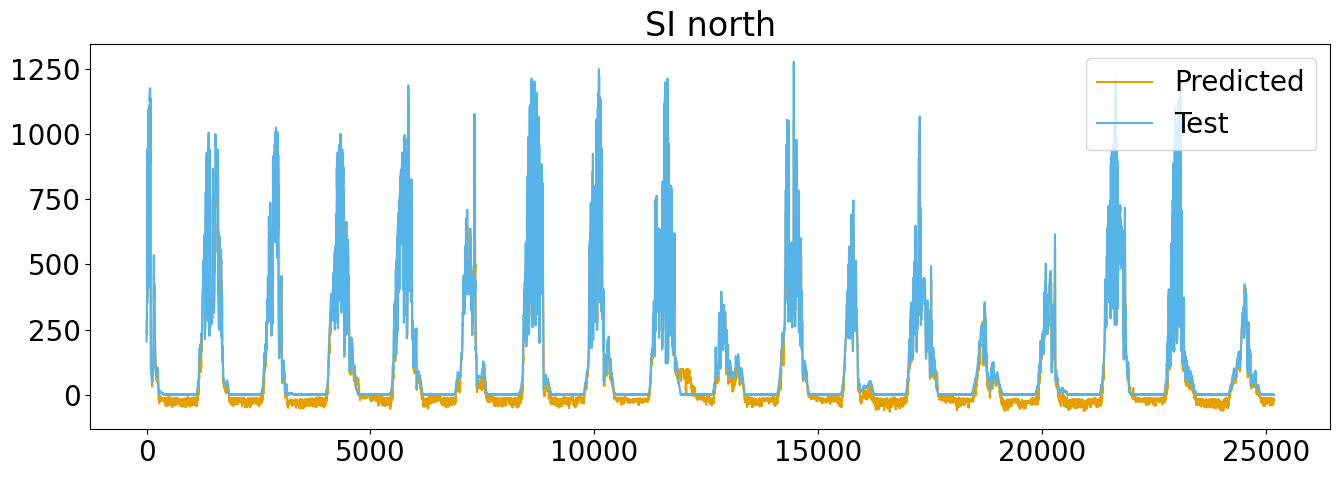

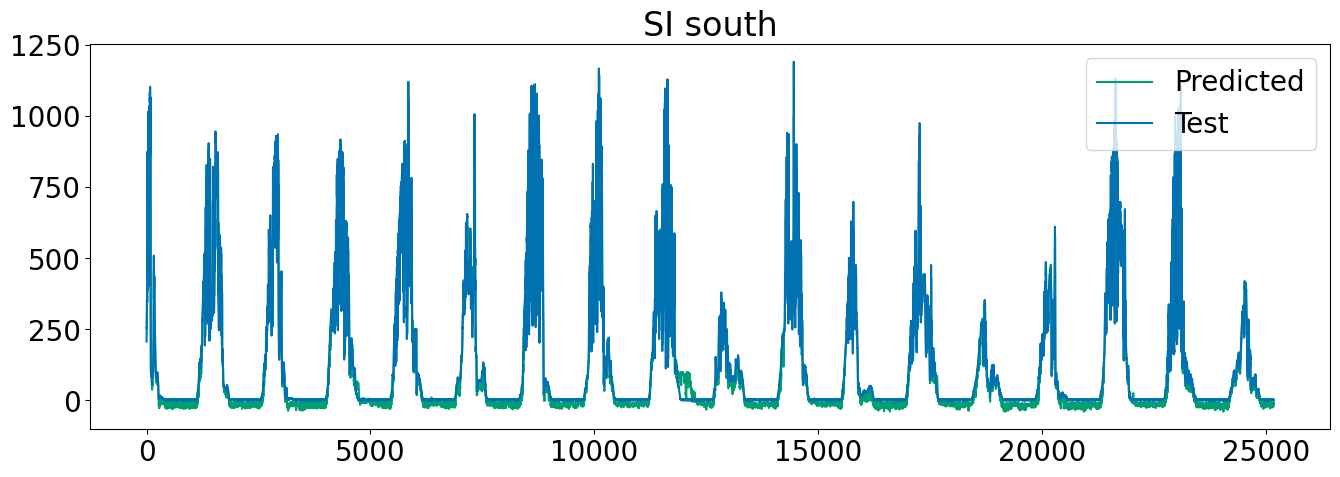

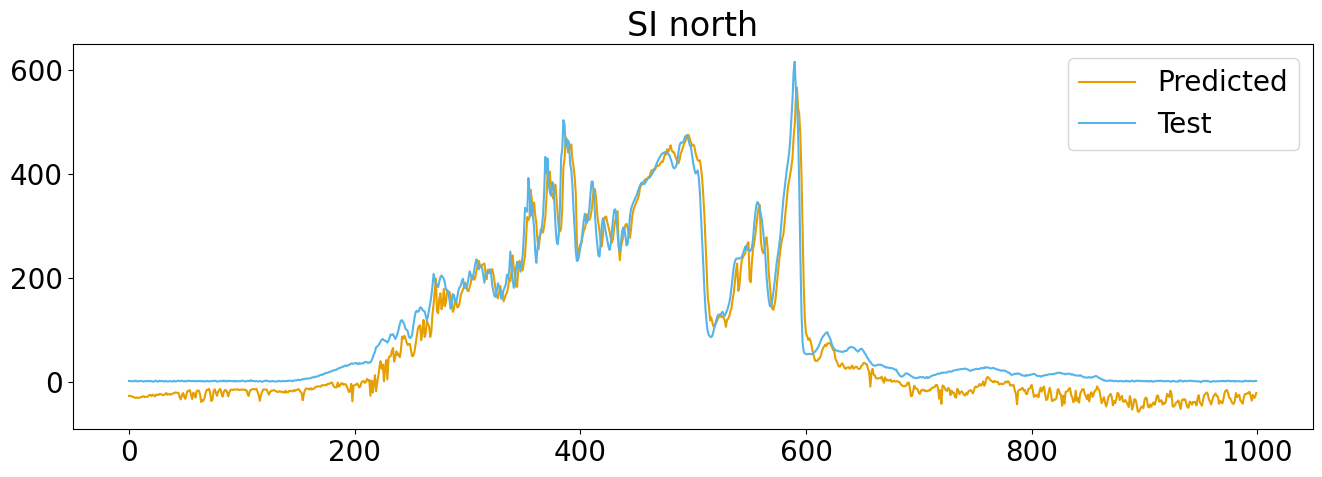

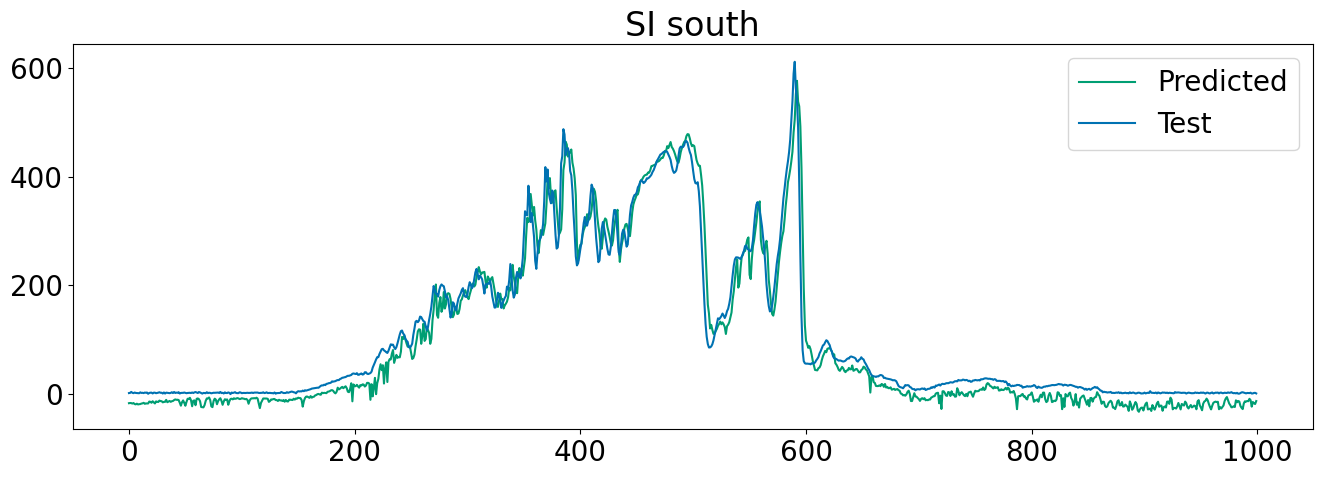

In [24]:
# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(16, 5))
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(y_test[:,0], color="#56B4E9", label='Test')
plt.title("SI north")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[:,1], color="#009E73", label='Predicted')
plt.plot(y_test[:,1], color="#0072B2", label='Test')
plt.title("SI south")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[19700:20700,0], color="#E69F00", label='Predicted')
plt.plot(y_test[19700:20700,0], color="#56B4E9", label='Test')
plt.title("SI north")
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(y_predict[19700:20700,1], color="#009E73", label='Predicted')
plt.plot(y_test[19700:20700,1], color="#0072B2", label='Test')
plt.title("SI south")
plt.legend()
plt.show()

6/6 [==============================] - 0s 7ms/step - loss: 0.0152 - mean_squared_error: 0.0152
loss:  [0.015228141099214554, 0.015228141099214554]


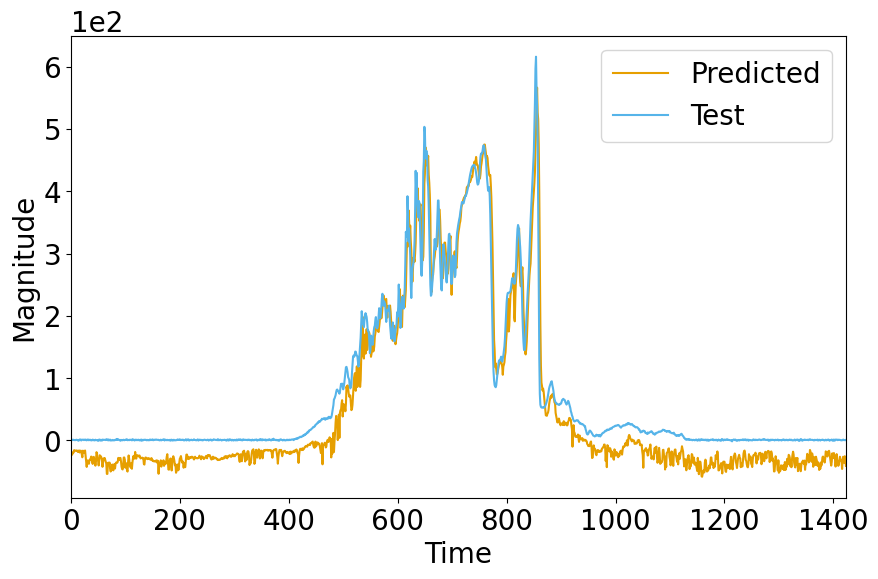

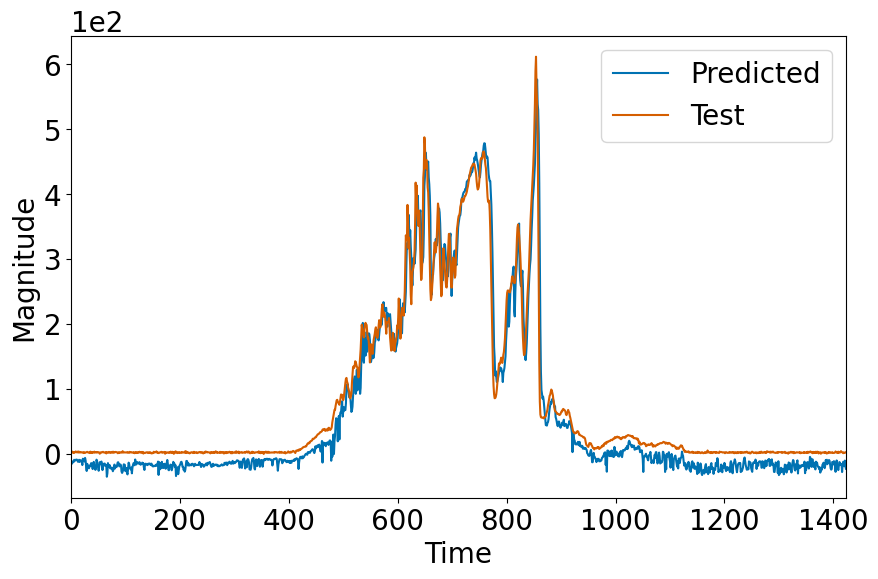

In [25]:
# apply to unseen data
# 2023-12-28
data_new = pd.read_csv('data/2023-12/[170] 2023-12-28.txt',sep='	')

SI_data = data_new[['Tm', 'AvgGmod05_N_1','AvgGmod05_S_1', 'AvgHamb_1', 'AvgTamb_1', 'AvgTmod05_N_1', 'AvgTmod05_S_1', 'AvgWindS_1', 'AvgWindD_1']]
SI_data = SI_data.set_index('Tm')

SI_north = SI_data['AvgGmod05_N_1'].to_numpy()
SI_south = SI_data['AvgGmod05_S_1'].to_numpy()
Ambient_humidity = SI_data['AvgHamb_1'].to_numpy()
Ambient_temp = SI_data['AvgTamb_1'].to_numpy()
Temp_north = SI_data['AvgTmod05_N_1'].to_numpy()
Temp_south = SI_data['AvgTmod05_S_1'].to_numpy()
Wind_speed = SI_data['AvgWindS_1'].to_numpy()
Wind_direction = SI_data['AvgWindD_1'].to_numpy()

def generate_data(data):
  win_length = 15
  count = 0
  data_train = []
  data_test = []
  while count < len(data):
    if count + win_length + 1 < len(data):
      data_train.append(data[count:count+win_length])
      data_test.append(data[count+win_length+1])
      count = count + 1
    else:
      break
  return np.array(data_train).reshape(-1, win_length, 1), np.array(data_test).reshape(-1, 1)

SI_north_train, SI_north_test = generate_data(SI_north)
SI_south_train, SI_south_test = generate_data(SI_south)
Ambient_humidity_train, Ambient_humidity_test = generate_data(Ambient_humidity)
Ambient_temp_train, Ambient_temp_test = generate_data(Ambient_temp)
Temp_north_train, Temp_north_test = generate_data(Temp_north)
Temp_south_train, Temp_south_test = generate_data(Temp_south)
Wind_speed_train, Wind_speed_test = generate_data(Wind_speed)
Wind_direction_train, Wind_direction_test = generate_data(Wind_direction)

data_train = np.concatenate([SI_south_train, SI_north_train, Ambient_humidity_train, Ambient_temp_train, Temp_north_train, Temp_south_train, Wind_speed_train, Wind_direction_train], axis=2)
data_test = np.concatenate([SI_south_test, SI_north_test], axis=1)

win_length = 15
X = scaler_X.transform(data_train.reshape(-1, 8)).reshape(-1, win_length, 8)
y = scaler_y.transform(data_test.reshape(-1, 2)).reshape(-1, 2)

y_predict = model.predict(X)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

loss = model.evaluate(X, y, batch_size=256)
print('loss: ', loss)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(data_test[:,0], color="#56B4E9", label='Test')
# plt.title("SI north")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_north_icrnn_64_testing.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_predict[:,1], color="#0072B2", label='Predicted')
plt.plot(data_test[:,1], color="#D55E00", label='Test')
# plt.title("SI south")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_south_icrnn_64_testing.pdf')
plt.show()

5/5 [==============================] - 0s 4ms/step - loss: 0.0133 - mean_squared_error: 0.0133
loss:  [0.013251726515591145, 0.013251726515591145]


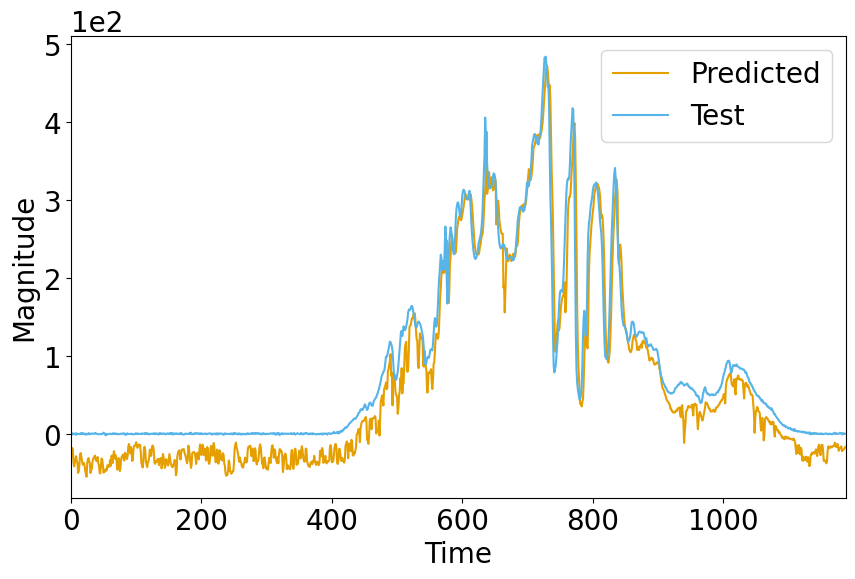

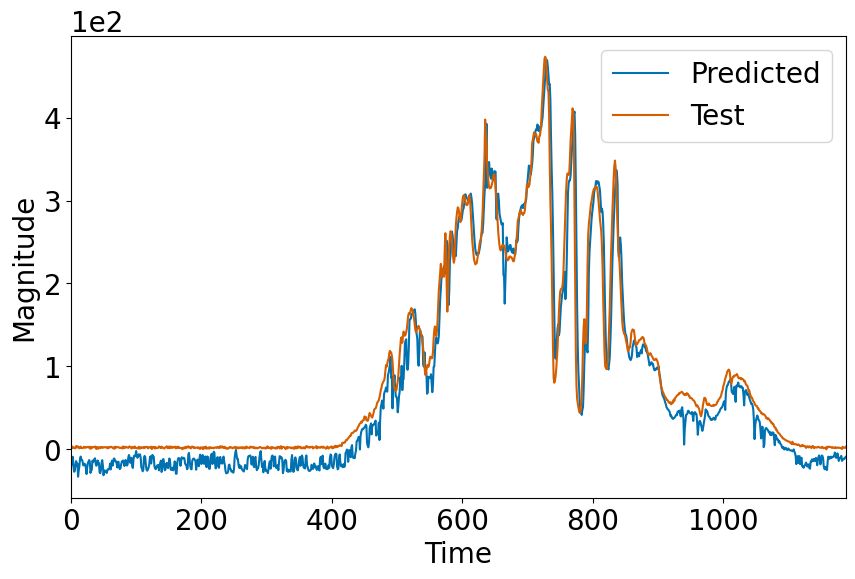

In [26]:
# apply to unseen data
# 2024-01-01
data_new = pd.read_csv('data/2024-01/[170] 2024-01-01.txt',sep='	')

SI_data = data_new[['Tm', 'AvgGmod05_N_1','AvgGmod05_S_1', 'AvgHamb_1', 'AvgTamb_1', 'AvgTmod05_N_1', 'AvgTmod05_S_1', 'AvgWindS_1', 'AvgWindD_1']]
SI_data = SI_data.set_index('Tm')

SI_north = SI_data['AvgGmod05_N_1'].to_numpy()
SI_south = SI_data['AvgGmod05_S_1'].to_numpy()
Ambient_humidity = SI_data['AvgHamb_1'].to_numpy()
Ambient_temp = SI_data['AvgTamb_1'].to_numpy()
Temp_north = SI_data['AvgTmod05_N_1'].to_numpy()
Temp_south = SI_data['AvgTmod05_S_1'].to_numpy()
Wind_speed = SI_data['AvgWindS_1'].to_numpy()
Wind_direction = SI_data['AvgWindD_1'].to_numpy()

def generate_data(data):
  win_length = 15
  count = 0
  data_train = []
  data_test = []
  while count < len(data):
    if count + win_length + 1 < len(data):
      data_train.append(data[count:count+win_length])
      data_test.append(data[count+win_length+1])
      count = count + 1
    else:
      break
  return np.array(data_train).reshape(-1, win_length, 1), np.array(data_test).reshape(-1, 1)

SI_north_train, SI_north_test = generate_data(SI_north)
SI_south_train, SI_south_test = generate_data(SI_south)
Ambient_humidity_train, Ambient_humidity_test = generate_data(Ambient_humidity)
Ambient_temp_train, Ambient_temp_test = generate_data(Ambient_temp)
Temp_north_train, Temp_north_test = generate_data(Temp_north)
Temp_south_train, Temp_south_test = generate_data(Temp_south)
Wind_speed_train, Wind_speed_test = generate_data(Wind_speed)
Wind_direction_train, Wind_direction_test = generate_data(Wind_direction)

data_train = np.concatenate([SI_south_train, SI_north_train, Ambient_humidity_train, Ambient_temp_train, Temp_north_train, Temp_south_train, Wind_speed_train, Wind_direction_train], axis=2)
data_test = np.concatenate([SI_south_test, SI_north_test], axis=1)

win_length = 15
X = scaler_X.transform(data_train.reshape(-1, 8)).reshape(-1, win_length, 8)
y = scaler_y.transform(data_test.reshape(-1, 2)).reshape(-1, 2)

y_predict = model.predict(X)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,2)

loss = model.evaluate(X, y, batch_size=256)
print('loss: ', loss)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)
plt.plot(y_predict[:,0], color="#E69F00", label='Predicted')
plt.plot(data_test[:,0], color="#56B4E9", label='Test')
# plt.title("SI north")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_north_icrnn_64_unseen.pdf')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_predict[:,1], color="#0072B2", label='Predicted')
plt.plot(data_test[:,1], color="#D55E00", label='Test')
# plt.title("SI south")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('si_south_icrnn_64_unseen.pdf')
plt.show()